## 3. Structure discovery for the Lorenz-96 problem

In this notebook, we will show how we can estimate the conditional independence structure of a random variable $\mathsf{X} \in \mathbb{R}^{N_x}$ with density $\pi$ based on i.i.d. samples $\{\boldsymbol{x}^i\}, \; i = 1, \ldots, N_e$ from $\pi$.

Baptista et al.[3] showed that the conditional independence properties of a random variable $\mathsf{X} \in \mathbb{R}^n$ with density $\pi$ are specified by the *Hessian score matrix* $\boldsymbol{\Omega} \in \mathbb{R}^{n \times n}$ defined as:

\begin{equation}
\Omega_{i,j} = \mathrm{E}_{\pi} \left[ |\partial_i\partial_j \log \pi(\boldsymbol{x})|^2  \right] = \int |\partial_i\partial_j \log \pi(\boldsymbol{x})|^2 \pi(\boldsymbol{x}) \; \mathrm{d}\boldsymbol{x}.
\end{equation}

The pullback density $\boldsymbol{S}^{\sharp} \rho$ can be used to approximate the true density $\pi$, where $\rho$ denotes the standard Gaussian distribution of $\mathbb{R}^n$. Thus, the score matrix is estimated by [3]: 
\begin{equation}
\hat{\Omega}_{i,j} = \mathrm{E}_{\pi} \left[ |\partial_i\partial_j \log \boldsymbol{S}^{\sharp} \rho|^2  \right]
\end{equation}

In practice, we use a sampled-based approximation $\hat{\boldsymbol{\Omega}}$ from the samples $\{\boldsymbol{x}^i\}, \; i=1,\ldots, N_e$ of $\pi$:


\begin{equation}
\hat{\Omega}_{i,j} \approx \sum_{k=1}^{N_e}|\partial_i\partial_j \log \boldsymbol{S}^{\sharp}\rho(\boldsymbol{x}^k )|^2
\end{equation}


We illustrate the estimation of the Hessian score on the invariant distribution (asymptotic distribution) of the Lorenz-96 model. The Lorenz-96 model [1] is a famous problem used in data assimilation and weather prediction. It was derived from first principles as a one-dimensional model for the response of the mid-latitude atmosphere to forcing input. For certain forcing input, it can exhibit a chaotic behavior: sensitivity to initial conditions, strong mixing. In this notebook, we consider the twenty-dimensional version of the Lorenz-96 model.  The state $\boldsymbol{x} = (x_1, \ldots, x_{20})$ at time $t$ is governed by the following set of ordinary differential equations:  

\begin{equation}
    \frac{\mathrm{d}x_i}{\mathrm{d}t} = (x_{i+1} - x_{i-2}) x_{i-1} -x_i + F,
\end{equation}
where it is assumed that $x_{-1} = x_{n − 1} , x_0 = x_{n}$ and $x_{n+1} = x_1$, setting the forcing input $F=8.0$ leads to chaos.


References: 

[1] Lorenz, E.N., 1996, September. Predictability: A problem partly solved. In Proc. Seminar on predictability (Vol. 1, No. 1).

[2] Baptista, R., Zahm, O., & Marzouk, Y. (2020). An adaptive transport framework for joint and conditional density estimation. arXiv preprint arXiv:2009.10303.

[3] Baptista, R., Marzouk, Y., Morrison, R.E. and Zahm, O., 2021. Learning non-Gaussian graphical models via Hessian scores and triangular transport. arXiv preprint arXiv:2101.03093.

In [14]:
using Revise
using LinearAlgebra
using TransportBasedInference
using Statistics
using Distributions
using OrdinaryDiffEq
using ProgressMeter
using LoopVectorization

Load some packages to make nice figures

In [2]:
using Plots
default(fontfamily = "Computer Modern",
        tickfont = font("Computer Modern", 9), 
        titlefont = font("Computer Modern", 14), 
        guidefont = font("Computer Modern", 12),
        legendfont = font("Computer Modern", 10),
        grid = false)

using LaTeXStrings

To generate i.i.d. samples from the invariant distribution of the Lorenz-96 problem, we use $N_e$ samples from the standard normal distribution (i.e. with zero mean and identity covariance matrix). For each initial condition (i.e. for each sample), we solve the set of ODEs of the Lorenz-96 problem over  $Tsteps =  40,000$ steps using a fourth order Runge-Kutta method with a time-step of $\Delta t= 0.01$. The samples of the state at the final time can be considered as i.i.d. samples of the push-forward distribution of the standard Gaussian through the nonlinear forward dynamics for $Tstep$.

We integrate the Lorenz-96 problem with our favorite ODE library: OrdinaryDiffEq.jl.

In [3]:
function lorenz96!(du,u,p,t)
    F = 8.0
    n = size(u,1)
    du[1] = (u[2]-u[end-1])*u[end] - u[1] + F
    du[2] = (u[3]-u[end])*u[1] - u[2] + F
    du[end] = (u[1] - u[end-2])*u[end-1] - u[end] + F

    @inbounds for i=3:n-1
        du[i] = (u[i+1] - u[i-2])*u[i-1] - u[i] + F
    end
    return du
end

lorenz96! (generic function with 1 method)

In [49]:
# Define the distribution for initial condition
Nx = 20
# Number of runs
Ne = 1000
πx0 = MvNormal(zeros(Nx), ones(Nx))
# Zero vector of the size of the state
x0 = rand(πx0)

# Time stepp
tspan = (0.0, 500.0)
prob = ODEProblem(lorenz96!,x0, tspan)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 500.0)
u0: 20-element Vector{Float64}:
 -0.4616937619804573
  1.156425824949976
 -1.8049712862148402
 -0.101264353138247
  0.9864492947362126
 -0.37615006663480066
  0.7731172093196323
  0.5846598057649217
 -1.4046376772839566
 -0.858417429649534
  0.8220750943609626
 -1.708384410662927
 -1.5780321830505493
 -0.84179445155117
 -0.5430145756938025
  0.4595173105898522
 -0.35139835129736996
 -0.479428616600852
 -0.1851722749862751
 -0.21407590488236786

Create cache to store the different final solutions

In [50]:
X = zeros(Nx, Ne);

Solve Lorenz-96 model for the different initial conditions and store the solutions as the columns of `X`

In [51]:
@inbounds for i=1:Ne
    prob = remake(prob; u0 = rand(πx0))
    sol = solve(prob, Tsit5(), dt = 0.01, adaptive = false, dense = false, saveat = tspan[end], save_start = false)
    X[:,i] = deepcopy(sol.u[1])
end

We can use the adaptive transport map procedure to estimate the underlying distribution for the state $\mathsf{X}$.

In [58]:
m = 30
S = HermiteMap(m, X; diag = true);

In [59]:
Nx = 2
Ne = 50

atol = 1e-6

X = randn(Nx, Ne)

#Blist = [ProHermiteBasis(8); PhyHermiteBasis(8); CstProHermiteBasis(8); CstPhyHermiteBasis(8); CstLinProHermiteBasis(8); CstLinPhyHermiteBasis(8)]

b = ProHermiteBasis(8)
B = MultiBasis(b, Nx)

idx = [0 0; 0 1; 1 0; 1 1; 1 2]
truncidx = idx[1:2:end,:]
Nψ = 5

coeff = randn(Nψ)

f = ExpandedFunction(B, idx, coeff)
R = IntegratedFunction(f)

IntegratedFunction(8, 5, 2, Rectifier("softplus"), ExpandedFunction(8, 5, 2, MultiBasis(Basis of 8 functions: 0th -> 7th degree Probabilistic Hermite function
, 2), [0 0; 0 1; … ; 1 1; 1 2], [1, 2], [-0.08368023853432646, 0.8655799730998628, -0.35828479813785896, -0.46543557790374734, 0.45882553563754574]))

In [65]:
using Test
using ForwardDiff
using QuadGK

In [67]:
# Test hess_x
H = hess_x(R, X)
Ht = zeros(Nx, Nx)
function Hessian!(H, x)
    fill!(H, 0.0)

    H[1:Nx-1,1:Nx-1] .= ForwardDiff.hessian(y->begin
                        y[Nx] = 0.0
                        return R.f(y) end, x)[1:Nx-1,1:Nx-1]

    # Hessian of the integral term
    H[1:Nx-1,1:Nx-1] .+= (quadgk(t -> ForwardDiff.hessian(
    z-> R.g(ForwardDiff.gradient(y->R.f(y), vcat(z[1:end-1], t))[end]), x),
            0.0, x[end])[1])[1:Nx-1,1:Nx-1]

    # H[Nx,:] and H[:,Nx]
    H[:, Nx] .= ForwardDiff.gradient(z->R.g(ForwardDiff.gradient(y->R.f(y), z)[end]), x)
    H[Nx, :] .= H[:, Nx]
    return H
end

@inbounds for i=1:Ne
    @show norm(H[i,:,:] - Hessian!(Ht, X[:,i]))<atol
end

norm(H[i, :, :] - Hessian!(Ht, X[:, i])) < atol = true
norm(H[i, :, :] - Hessian!(Ht, X[:, i])) < atol = true
norm(H[i, :, :] - Hessian!(Ht, X[:, i])) < atol = true
norm(H[i, :, :] - Hessian!(Ht, X[:, i])) < atol = true
norm(H[i, :, :] - Hessian!(Ht, X[:, i])) < atol = true
norm(H[i, :, :] - Hessian!(Ht, X[:, i])) < atol = true
norm(H[i, :, :] - Hessian!(Ht, X[:, i])) < atol = true
norm(H[i, :, :] - Hessian!(Ht, X[:, i])) < atol = true
norm(H[i, :, :] - Hessian!(Ht, X[:, i])) < atol = true
norm(H[i, :, :] - Hessian!(Ht, X[:, i])) < atol = true
norm(H[i, :, :] - Hessian!(Ht, X[:, i])) < atol = true
norm(H[i, :, :] - Hessian!(Ht, X[:, i])) < atol = true
norm(H[i, :, :] - Hessian!(Ht, X[:, i])) < atol = true
norm(H[i, :, :] - Hessian!(Ht, X[:, i])) < atol = true
norm(H[i, :, :] - Hessian!(Ht, X[:, i])) < atol = true
norm(H[i, :, :] - Hessian!(Ht, X[:, i])) < atol = true
norm(H[i, :, :] - Hessian!(Ht, X[:, i])) < atol = true
norm(H[i, :, :] - Hessian!(Ht, X[:, i])) < atol = true
norm(H[i, 

In [53]:
optimize(S, X, "kfold"; withqr = true, verbose = false, hessprecond = true)

Hermite map of dimension 20:
Hermite map component of dimension 1 with Nψ = 7 active features
Hermite map component of dimension 2 with Nψ = 15 active features
Hermite map component of dimension 3 with Nψ = 27 active features
Hermite map component of dimension 4 with Nψ = 29 active features
Hermite map component of dimension 5 with Nψ = 28 active features
Hermite map component of dimension 6 with Nψ = 27 active features
Hermite map component of dimension 7 with Nψ = 26 active features
Hermite map component of dimension 8 with Nψ = 29 active features
Hermite map component of dimension 9 with Nψ = 24 active features
Hermite map component of dimension 10 with Nψ = 29 active features
Hermite map component of dimension 11 with Nψ = 8 active features
Hermite map component of dimension 12 with Nψ = 10 active features
Hermite map component of dimension 13 with Nψ = 10 active features
Hermite map component of dimension 14 with Nψ = 13 active features
Hermite map component of dimension 15 with N

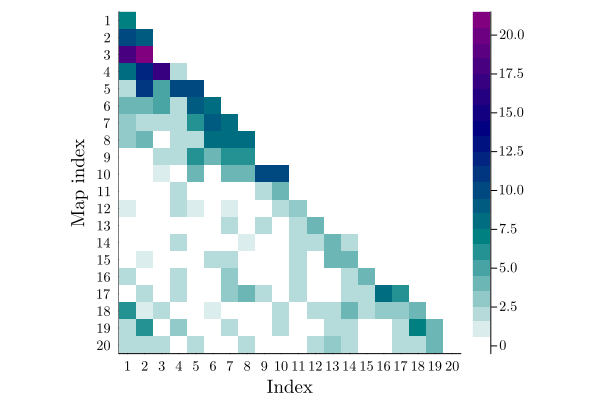

In [54]:
plot(S)
# savefig("Lorenz96_structure.pdf")

The function `hess_x_log_pdf!` computes in-place the Hessian of the log pdf of the pullback density $\boldsymbol{S}^{\sharp} \rho$. You can also use `hess_x_log_pdf`.

In [55]:
Ωhat = zeros(Nx, Nx)
cache = zeros(1, Nx, Nx)
@showprogress for i=1:Ne
    hess_x_log_pdf!(cache, S, X[:,i:i])
    Ωhat .+= copy(cache[1,:,:]).^2
end
rmul!(Ωhat, 1/Ne)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


20×20 Matrix{Float64}:
     2.80768e6  12495.9        14166.6        …  22788.3         3755.5
 12495.9            3.47445e6    225.143          1733.46       19939.6
 14166.6          225.143          1.12267e6        14.1466        16.2704
   157.683      51059.5         1619.55           1326.8            0.0
  1429.23        1347.94       17451.4               0.109332     537.919
   113.107       8614.99        3059.97       …      0.0            0.0
  1041.87          33.2795      2281.77            187.894          0.0
  1063.35         413.167         23.6143            0.710505     192.028
     0.0            0.0019818    407.231             0.0            0.0
    32.5831         1.04724        0.438155        840.456          0.0
     4.89113        1.68005        0.0        …      0.0            0.0
     0.567346      25.0608         0.0478726         0.58536      437.541
    70.5633        20.3566         2.47003        1068.81         592.519
    48.3612        29.4385    

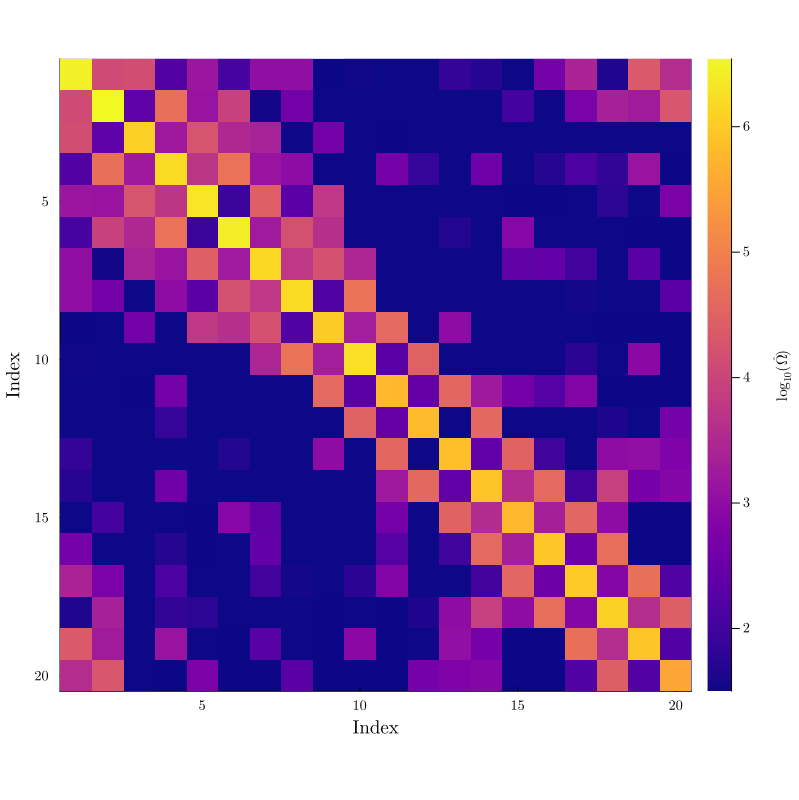

In [56]:
plt = plot(size = (800, 800))

heatmap!(plt,1:Nx, 1:Nx, log10.(Ωhat), ratio = 1, yflip = true, 
        colorbar = true, color = :plasma, clim = (1.5, Inf), colorbar_title = L"\log_{10}(\hat{\Omega})",
        xlabel = "Index", ylabel = "Index", background_color_inside = palette(:plasma)[1],
        ylims = (0.5,Nx+0.5))